## Imports and Setups

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils

In [108]:
# set constants and hyperparameters

DATASET_TEST = 'data/2023_quy1_test.csv'
# Minimum value: 20.5
# Maximum value: 32.5
# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [109]:
y = pd.read_csv(DATASET_TEST)

y.set_index('time', inplace=True)
y.index = pd.to_datetime(y.index)
y.sort_index(inplace=True)

print(f'Number of time stamps: {y.size}')
print(f'First 3 time stamps: {y.index[0]}, {y.index[1]}, {y.index[2]}')
print(f'Last 3 time stamps: {y.index[-3]}, {y.index[-2]}, {y.index[-1]}')

y.describe()

temp_test = y['temperature']
test = temp_test[(temp_test.index.year>=2022)]

test.head()

Number of time stamps: 10779
First 3 time stamps: 2023-01-01 00:17:01, 2023-01-01 00:19:03, 2023-01-01 00:41:58
Last 3 time stamps: 2023-03-27 20:50:42, 2023-03-27 21:14:50, 2023-03-27 21:25:27


time
2023-01-01 00:17:01    22.1
2023-01-01 00:19:03    22.9
2023-01-01 00:41:58    22.9
2023-01-01 00:43:16    21.9
2023-01-01 01:04:53    22.9
Name: temperature, dtype: float64

## Prepare Training Data


In [110]:
# apply preprocessing pipeline

test, t, x_win, t_win = preprocessing.new_apply_pipeline(test, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

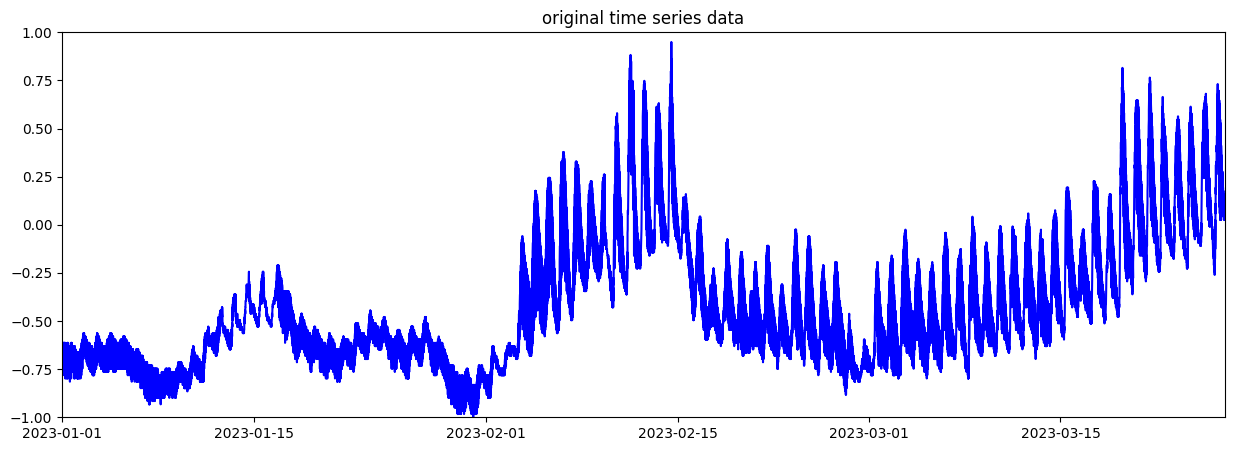

In [111]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, test, x_win=None, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series data')

In [112]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 10680
Start times of the first 3 windows: ['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000']


## Train Reconstruction Model (TadGAN)

In [113]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [ ]:
# train the model

t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
t1 = time.time()

model.save_model("./model/model_tran_100_quy1_test")

In [84]:
model.get_model("./model/model_tran_100_quy1")

In [18]:
print(x_win)

[[-0.73333333 -0.6        -0.6        ... -0.75       -0.61666667
  -0.75      ]
 [-0.6        -0.6        -0.76666667 ... -0.61666667 -0.75
  -0.61666667]
 [-0.6        -0.76666667 -0.6        ... -0.75       -0.61666667
  -0.75      ]
 ...
 [-0.01666667  0.01666667 -0.01666667 ...  0.16666667  0.48333333
   0.16666667]
 [ 0.01666667 -0.01666667 -0.01666667 ...  0.48333333  0.16666667
   0.18333333]
 [-0.01666667 -0.01666667  0.01666667 ...  0.16666667  0.18333333
   0.45      ]]


In [85]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)

In [22]:
print(x_win_recon)
print(len(x_win_recon))

[[-0.712169   -0.63242006 -0.6987239  ... -0.61287475 -0.6385426
  -0.6110431 ]
 [-0.7104908  -0.63182855 -0.6976069  ... -0.6120734  -0.6373476
  -0.6100833 ]
 [-0.71175915 -0.63225734 -0.6984344  ... -0.6126282  -0.6383413
  -0.61080694]
 ...
 [ 0.0871473   0.07513841  0.12290174 ...  0.14693011  0.16093308
   0.17810354]
 [ 0.08979023  0.0781244   0.12646876 ...  0.1361164   0.15065642
   0.16759804]
 [ 0.09571117  0.08417609  0.13228367 ...  0.12833464  0.14331755
   0.16013789]]
10712


In [14]:
print(critic_scores)

[6.529379  6.5057898 6.5362325 ... 8.135206  8.183654  8.173998 ]


IndexError: index 10614 is out of bounds for axis 0 with size 10614

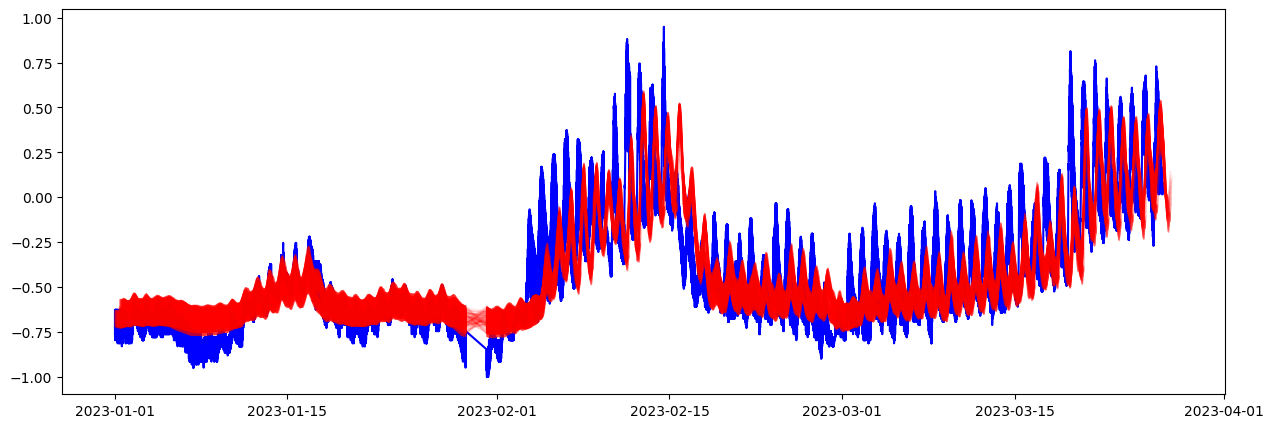

In [103]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, test, x_win=x_win_recon, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

In [73]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(test, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

In [20]:
print(t)

['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000' ... '2023-03-27T20:50:42.000000000'
 '2023-03-27T21:14:50.000000000' '2023-03-27T21:25:27.000000000']


In [21]:
print(test)

[-0.73333333 -0.6        -0.6        ...  0.16666667  0.18333333
  0.45      ]


In [76]:
print(detected_intervals)

[['2023-01-29T11:47:48.000000000' '2023-01-31T03:40:08.000000000']]


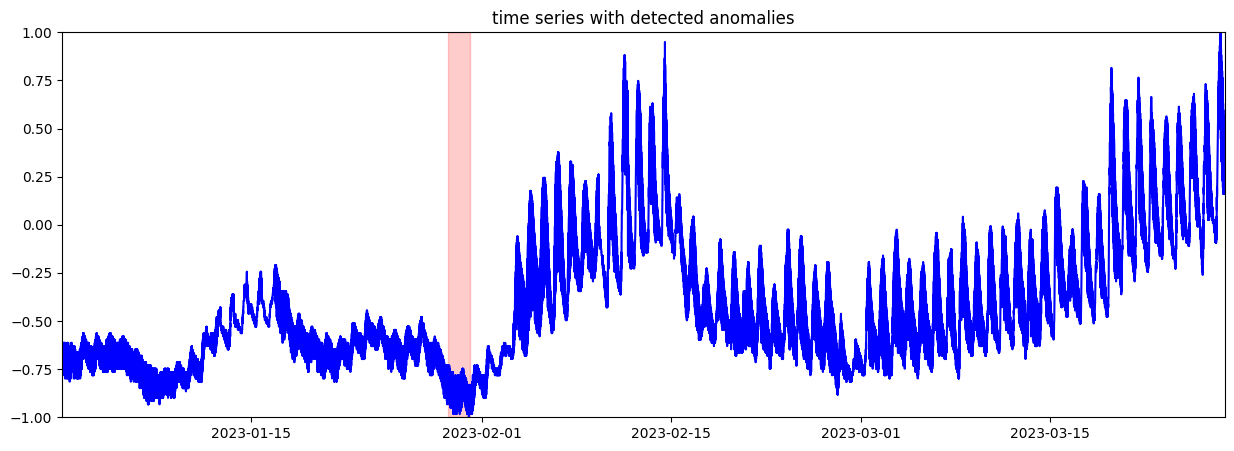

In [87]:
# plot time series with detected anomalies

utils.plot_time_series(t, test, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

In [34]:
test_model, t, x_win_test, t_win_test = preprocessing.new_apply_pipeline(test, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [35]:
x_win_recon_test, critic_scores_test = model.predict(x_win_test)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(x_win_test, x_win_recon_test)
mae = mean_absolute_error(x_win_test, x_win_recon_test)
r2 = r2_score(x_win_test, x_win_recon_test)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R Squared (R2):", r2)

Mean Squared Error (MSE): 0.03469282217892352
Mean Absolute Error (MAE): 0.10864650637070725
R Squared (R2): 0.5192465415856207


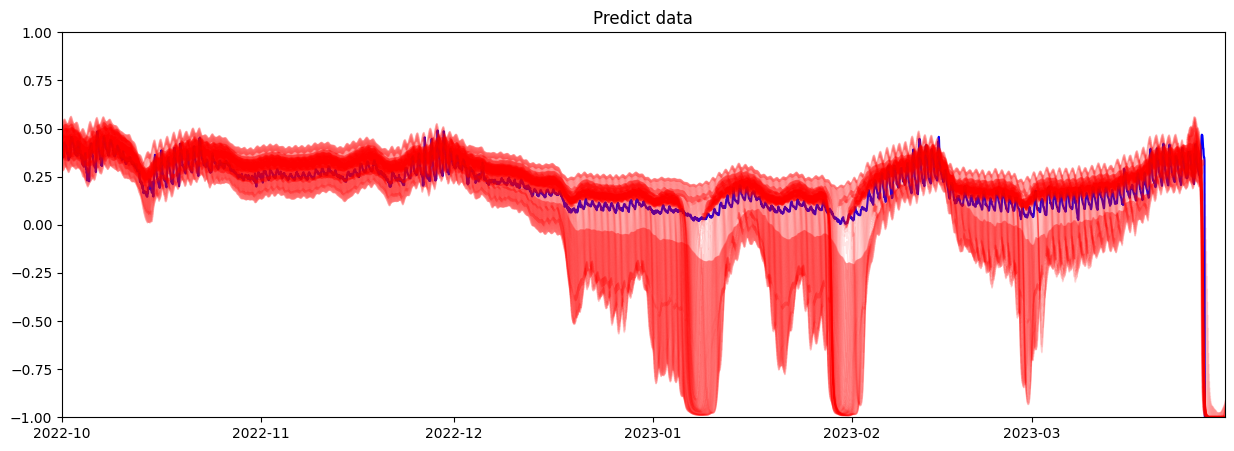

In [38]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, test_model, x_win=x_win_recon_test, 
                       date_range=['2022-10-01', '2023-03-31'], value_range=[-1, 1],
                       title='Predict data')

In [40]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(test_model, t, x_win_recon_test, critic_scores_test, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

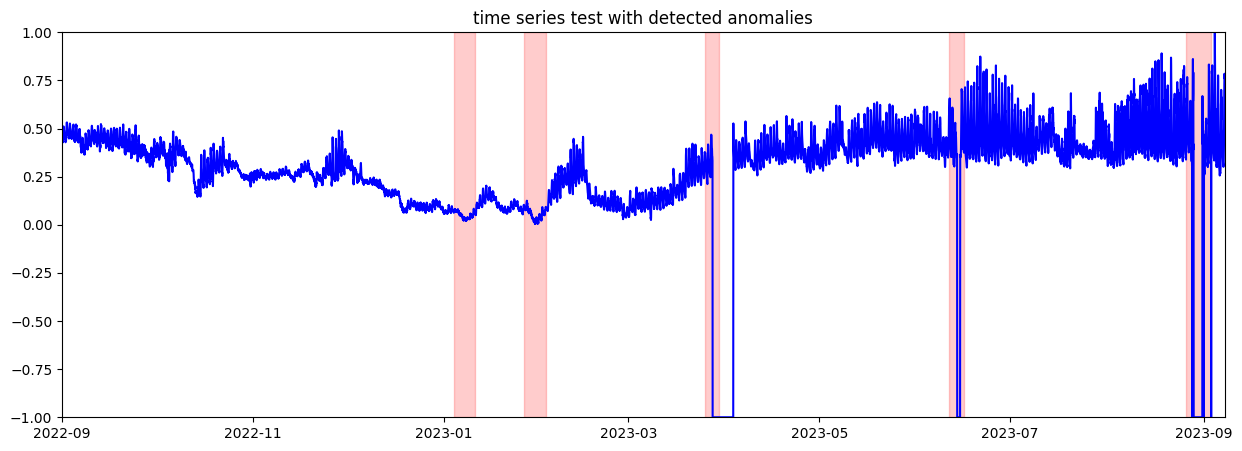

In [41]:
# plot time series with detected anomalies

utils.plot_time_series(t, test_model, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series test with detected anomalies')